# 🩻 Day 15 - Chest X-Ray Image Classification
### CNN-Based Classification of Chest X-Ray Images for Pneumonia Detection

A deep learning model that classifies chest X-ray images into Normal or Pneumonia using Convolutional Neural Networks.

In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings('ignore')
tf.random.set_seed(42)
np.random.seed(42)

print('All modules imported!')

All modules imported!


In [2]:
base_dir = 'chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

print("Train, validation, and test directories initialized!")

Train, validation, and test directories initialized!


In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# ----- Data generators -----
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    brightness_range=[0.6, 1.4],
    width_shift_range=0.2,
    height_shift_range=0.2,
    channel_shift_range=0.1
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
classes = train_generator.classes
class_labels = np.unique(classes)
class_weight_values = compute_class_weight('balanced', classes=class_labels, y=classes)
class_weight = {int(k): float(v) for k, v in zip(class_labels, class_weight_values)}

print('Class weights:', class_weight)

Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [5]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(256, (3,3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 111, 111, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 406,849 (1.55 MB)

 Trainable params: 405,889 (1.55 MB)

 Non-trainable params: 960 (3.75 KB)

In [6]:
EPOCHS = 25

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    min_lr=1e-6
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint, lr_scheduler],
    class_weight=class_weight
)

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.7855 - loss: 0.6994 - val_accuracy: 0.5000 - val_loss: 3.5267 - learning_rate: 0.0010
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.8357 - loss: 0.5365 - val_accuracy: 0.5000 - val_loss: 3.2320 - learning_rate: 0.0010
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.8455 - loss: 0.4625 - val_accuracy: 0.6250 - val_loss: 1.7458 - learning_rate: 0.0010
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 457s 3s/step - accuracy: 0.8545 - loss: 0.4149 - val_accuracy: 0.5625 - val_loss: 1.1926 - learning_rate: 0.0010
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 886s 5s/step - accuracy: 0.8597 - loss: 0.3984 - val_accuracy: 0.5000 - val_loss: 2.1980 - learning_rate: 0.0010
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 553s 3s/step - accuracy: 0.8620 - loss: 0.3881 - val_accuracy: 0.5000 - val_loss: 1.7312 - learning_rate: 0.0010
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 457s 3s/step - accuracy: 0.8898 - loss: 0.

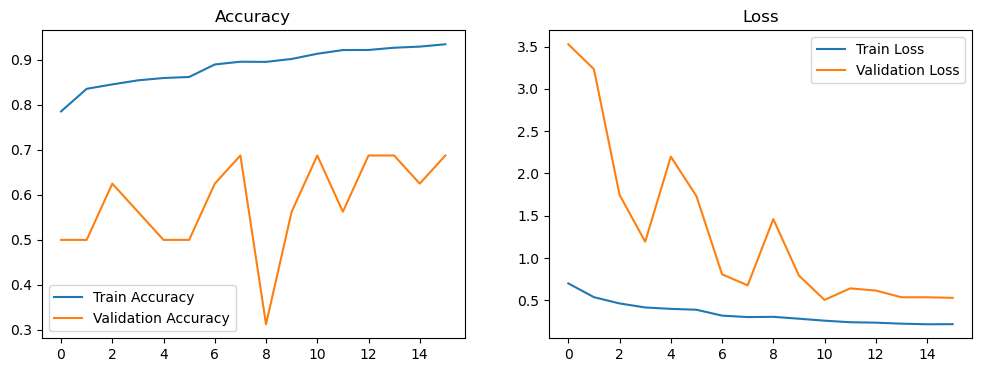

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [8]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc*100:.2f}%')

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 505ms/step - accuracy: 0.8590 - loss: 0.3701
Test Accuracy: 85.90%


In [9]:
pred_probs = model.predict(test_generator, verbose=1)
preds = (pred_probs > 0.5).astype(int).ravel()
y_true = test_generator.classes

print("Prediction probabilities, predicted labels, and true labels extracted.")

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step
Prediction probabilities, predicted labels, and true labels extracted.


In [10]:
print('Classification Report:\n', classification_report(y_true, preds, target_names=['NORMAL', 'PNEUMONIA']))

Classification Report:
               precision    recall  f1-score   support

      NORMAL       0.76      0.91      0.83       234
   PNEUMONIA       0.94      0.83      0.88       390

    accuracy                           0.86       624
   macro avg       0.85      0.87      0.85       624
weighted avg       0.87      0.86      0.86       624



In [11]:
cm = confusion_matrix(y_true, preds)
print('Confusion Matrix:\n', cm)

Confusion Matrix:
 [[212  22]
 [ 66 324]]


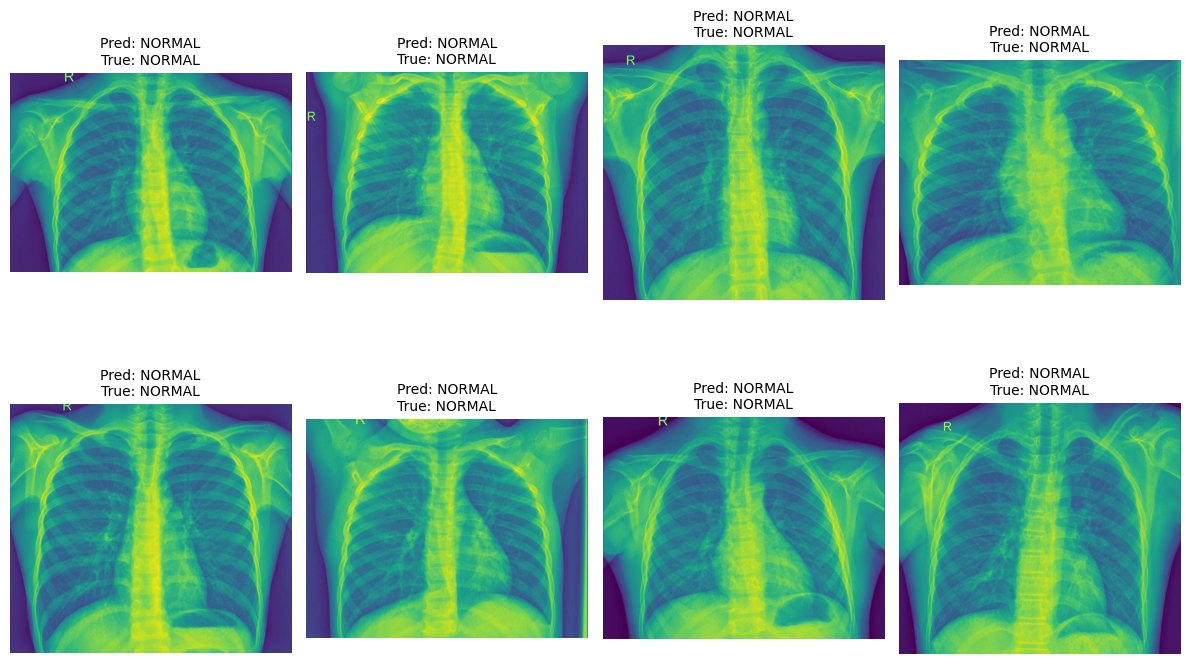

In [12]:
plt.figure(figsize=(12, 8))
num_show = min(8, len(test_generator.filepaths))

for i in range(num_show): 
    img_path = test_generator.filepaths[i]  
    img = mpimg.imread(img_path)

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)

    true_label = "PNEUMONIA" if y_true[i] == 1 else "NORMAL"
    pred_label = "PNEUMONIA" if preds[i] == 1 else "NORMAL"

    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
model.save('pneumonia_detector_model.keras')
print('Model saved successfully!')

Model saved successfully!
